In [1]:
from alphatools.research import run_pipeline, make_factor_plot
from alphatools.expression import ExpressionAlpha
from zipline.pipeline.factors import AverageDollarVolume
from zipline.pipeline import Pipeline

In [2]:
universe = AverageDollarVolume(window_length=120).top(500)

In [9]:
expr_factor = (
    ExpressionAlpha('rank(log(close/delay(close, 5)))').
    pipeline_factor(mask=universe)
)

In [10]:
p = Pipeline(screen=universe)
p.add(expr_factor, "Expression Alpha")

start_date = '2017-01-04'
end_date = '2017-12-28'

df = run_pipeline(p, start_date, end_date)


Formatting factor data for: Expression Alpha
Dropped 1.5% entries from factor data: 1.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Time to get arrange factor data: 1.10 secs
Time to generate long/short returns: 0.13 secs


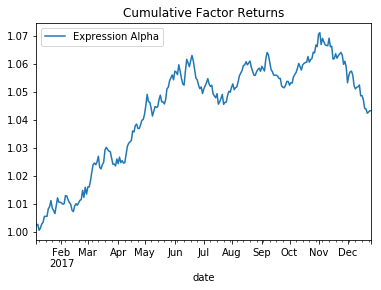

In [11]:
make_factor_plot(df, start_date, end_date);

In [3]:
e = ExpressionAlpha('rank(log(close/delay(opens, 5)))')

In [4]:
print(e.pipeline_code)

class ExprAlpha_1(CustomFactor):
    inputs = [USEP.open, USEP.high, USEP.low, USEP.close]
    window_length = 7

    def compute(self, today, assets, out, opens, high, low, close):
        v0 = np.roll(opens, 5)
        v1 = close/v0
        v2 = np.log(v1)
        v3 = np.apply_along_axis(rankdata, 1, v2)
        out[:] = v3[-1]

